<a href="https://colab.research.google.com/github/nikitia/data_science_projects/blob/main/cheminformatics_predicting_solubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cheminformatics in Python: Predicting Solubility of Molecules | End-to-End Data Science Project** 


<i>[Data Professor YouTube channel](http://youtube.com/dataprofessor), http://youtube.com/dataprofessor </i>

In this notebook, I will dive into the world of Cheminformatics which lies at the interface of Informatics and Chemistry. I will be reproducing a research article (by John S. Delaney$^1$) by applying Linear Regression to predict the solubility of molecules (i.e. solubility of drugs is an important physicochemical property in Drug discovery, design and development).

This idea for this notebook was inspired by the excellent blog post by Pat Walters$^2$ where he reproduced the linear regression model with similar degree of performance as that of Delaney. This example is also briefly described in the book ***Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More***.$^3$

## **1. Install rdkit**

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-12-15 08:39:47--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   111MB/s    in 0.7s    

2022-12-15 08:39:47 (111 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6

## **2. Delaney's solubility dataset**

The original [Delaney's dataset](https://pubs.acs.org/doi/10.1021/ci034243x) available as a [Supplementary file](https://pubs.acs.org/doi/10.1021/ci034243x)$^4$. The full paper is entitled [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x).$^1$

### **2.1. Download the dataset**

In [ ]:
# original link not available
# ! wget https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
# download from GitHub below

In [2]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2022-12-15 08:41:32--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.008s  

2022-12-15 08:41:32 (6.69 MB/s) - ‘delaney.csv’ saved [58889/58889]



### **2.2. Read in the dataset**

In [3]:
import pandas as pd

In [4]:
sol = pd.read_csv('delaney.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


### **2.3. Examining the SMILES data**

Chemical structures are encoded by a string of text known as **SMILES** which is an acronym for **Simplified Molecular-Input Line-Entry System**.

In [5]:
# dataframe.SMILES function
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

The first element from the **SMILES** column of the **sol** dataframe.

In [6]:
# get first row
sol.SMILES[0]

'ClCC(Cl)(Cl)Cl'

### **2.4. Convert a molecule from the SMILES string to an rdkit object**

In [7]:
# rdkit to comprehend information of chem structure
# read ir in to rdkit
# convert SMILES notation azkey text into rdkit object
from rdkit import Chem

In [8]:
# either
Chem.MolFromSmiles(sol.SMILES[0])

In [9]:
# or
Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

### **2.5. Working with rdkit object**

In [10]:
# assign rdkit object to 'm' variable
m = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

In [11]:
# find the number of atoms
m.GetNumAtoms()

6

## **3. Calculate molecular descriptors in rdkit**

### **3.1. Convert list of molecules to rdkit object**

In [12]:
# to calculate molecular dicsriptors use Chem sub module in rdkit
from rdkit import Chem

#### **3.1.1. Method 1**

In [13]:
# original for loop form
# create empty list
# iterate for each element in sol.SMILES list
# convert element into rdkit object
# assign rdkit object to mol variable
# append mol variable to list
mol_list= []
for element in sol.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [14]:
len(mol_list)

1144

In [15]:
mol_list[:5]

#### **3.1.2. Method 2**

In [16]:
# concise for loop
mol_list2 = [Chem.MolFromSmiles(element) for element in sol.SMILES]

In [17]:
len(mol_list2)

1144

In [18]:
mol_list2[:5]

### **3.2. Calculate molecular descriptors**

To predict **LogS** (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:
1. **cLogP** *(Octanol-water partition coefficient)*
2. **MW** *(Molecular weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms / total number of heavy atoms)*

Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the *number of aromatic atoms* to the *total number of heavy atoms* which rdkit can compute.

#### **3.2.1. LogP, MW and RB**

In [19]:
import numpy as np
from rdkit.Chem import Descriptors

In [20]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):
# convert smiles to rdkit object
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
  # compute decriptors     
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
 # return descriptors in pandas df   
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [21]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#### **3.2.2. Aromatic proportion**

##### 3.2.1.1. Number of aromatic atoms

Here, we will create a custom function to calculate the **Number of aromatic atoms**. With this descriptor we can use it to subsequently calculate the AP descriptor.

Computing for a single molecule.

In [22]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')

In [23]:
# retrieve each atom determine aromaticity
aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [24]:
# count all true aromatic atoms
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [25]:
AromaticAtoms(m)

19

Computing for molecules in the entire dataset.

In [26]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

##### 3.2.1.2. **Number of heavy atoms**

Here, we will use an existing function for calculating the Number of heavy atoms.

Computing for a single molecule.

In [27]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
Descriptors.HeavyAtomCount(m)

34

Computing for molecules in the entire dataset.

In [28]:
# retrieve each atom determine heavy atoms
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

##### **3.2.1.3. Computing the Aromatic Proportion (AP) descriptor**

Computing for a single molecule.

In [29]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AromaticAtoms(m)/Descriptors.HeavyAtomCount(m)

0.5588235294117647

Computing for molecules in the entire dataset.

In [30]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [31]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


### **3.3. X matrix (Combining all computed descriptors into 1 dataframe)**

In [32]:
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [33]:
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


Let's combine the 2 dataframes to produce the **X** matrix

In [34]:
# join dfs
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


### **3.4. Y matrix**

In [35]:
# prdict solubility
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


Assigning the second column (index 1) to the Y matrix

In [36]:
#select 2nd column
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

---

## **Data split**

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## **Linear Regression Model**

In [39]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

### **Predicts the X_train**

In [41]:
# apply model for prediction 
Y_pred_train = model.predict(X_train)

In [42]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.73718069 -0.00667099  0.00273331 -0.45644308]
Intercept: 0.26611776214147387
Mean squared error (MSE): 1.00
Coefficient of determination (R^2): 0.78


### **Predicts the X_test**

In [43]:
Y_pred_test = model.predict(X_test)

In [44]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.73718069 -0.00667099  0.00273331 -0.45644308]
Intercept: 0.26611776214147387
Mean squared error (MSE): 1.04
Coefficient of determination (R^2): 0.74


### **Linear Regression Equation**

The work of Delaney$^1$ provided the following linear regression equation:

> LogS = 0.16 -  0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP

The reproduction by Pat Walters$^2$ provided the following:

> LogS = 0.26 -  0.74 LogP - 0.0066 MW + 0.0034 RB - 0.42 AP

This notebook's reproduction gave the following equation:

* Based on the Train set
> LogS = 0.30 -0.75 LogP - .0066 MW -0.0041 RB - 0.36 AP

* Based on the Full dataset
> LogS =  0.26 -0.74 LogP - 0.0066 + MW 0.0032 RB - 0.42 AP

#### **Our linear regression equation**

In [45]:
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' % (model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3] ) )

LogS = 0.27 -0.74 LogP -0.0067 MW 0.0027 RB -0.46 AP


The same equation can also be produced with the following code (which breaks up the previous one-line code into several comprehensible lines.

In [46]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]

In [47]:
print('LogS = ' + 
      ' ' + 
      yintercept + 
      ' ' + 
      LogP + 
      ' ' + 
      MW + 
      ' ' + 
      RB + 
      ' ' + 
      AP)

LogS =  0.27 -0.74 LogP -0.0067 MW 0.0027 RB -0.46 AP


#### **Use entire dataset for model training (For Comparison)**

In [48]:
full = linear_model.LinearRegression()
full.fit(X, Y)

LinearRegression()

In [49]:
full_pred = model.predict(X)

In [50]:
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [51]:
full_yintercept = '%.2f' % full.intercept_
full_LogP = '%.2f LogP' % full.coef_[0]
full_MW = '%.4f MW' % full.coef_[1]
full_RB = '+ %.4f RB' % full.coef_[2]
full_AP = '%.2f AP' % full.coef_[3]

In [52]:
print('LogS = ' + 
      ' ' + 
      full_yintercept + 
      ' ' + 
      full_LogP + 
      ' ' + 
      full_MW + 
      ' ' + 
      full_RB + 
      ' ' + 
      full_AP)

LogS =  0.26 -0.74 LogP -0.0066 MW + 0.0032 RB -0.42 AP


## **Scatter plot of experimental vs. predicted LogS**

In [53]:
import matplotlib.pyplot as plt

### **Quick check of the variable dimensions of Train and Test sets**

In [54]:
Y_train.shape, Y_pred_train.shape

((915,), (915,))

In [55]:
Y_test.shape, Y_pred_test.shape

((229,), (229,))

### **Vertical plot**

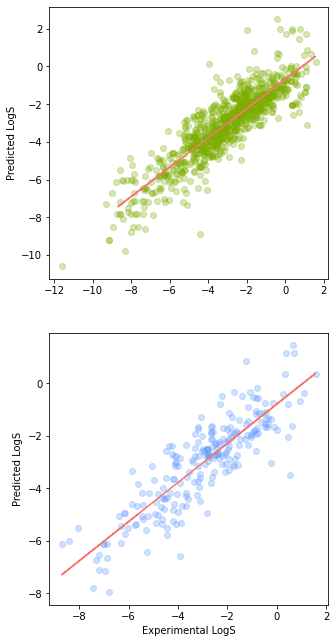

In [56]:
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

### **Horizontal plot**

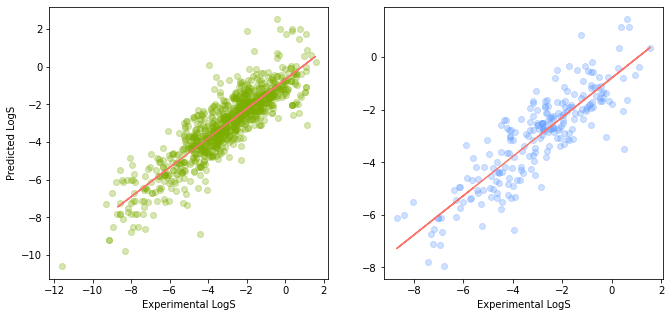

In [57]:
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()

In [58]:
! ls -l

total 83296
-rw-r--r-- 1 root root    58889 Dec 15 08:41 delaney.csv
-rwxr-xr-x 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh
-rw-r--r-- 1 root root    30130 Dec 15 09:06 plot_horizontal_logS.pdf
-rw-r--r-- 1 root root    50088 Dec 15 09:06 plot_horizontal_logS.png
-rw-r--r-- 1 root root    30131 Dec 15 09:06 plot_vertical_logS.pdf
-rw-r--r-- 1 root root    51192 Dec 15 09:06 plot_vertical_logS.png
drwxr-xr-x 1 root root     4096 Dec 13 14:35 sample_data


---

## **Reference**

1. John S. Delaney. [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x). ***J. Chem. Inf. Comput. Sci.*** 2004, 44, 3, 1000-1005.

2. Pat Walters. [Predicting Aqueous Solubility - It's Harder Than It Looks](http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html). ***Practical Cheminformatics Blog***

3. Bharath Ramsundar, Peter Eastman, Patrick Walters, and Vijay Pande. [Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More](https://learning.oreilly.com/library/view/deep-learning-for/9781492039822/), O'Reilly, 2019.

4. [Supplementary file](https://pubs.acs.org/doi/10.1021/ci034243x) from Delaney's ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure.